In [1]:
import librosa as librosa
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
%matplotlib inline
import librosa.display
from IPython.display import Audio
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import splitfolders
import skimage.io

2024-05-21 15:21:10.392394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/var/folders/61/j5hgpw591h5654xxhycthpfm0000gn/T/ipykernel_70419/977094167.py:2: FutureWarning: waveshow() keyword argument 'x_axis' has been renamed to 'axis' in version 0.10.0.
	This alias will be removed in version 1.0.
  librosa.display.waveshow(y, max_points=11025, x_axis='s')


The sampled audio is returned as a numpy array (TS) and has  (105771,)  number of samples
The 10 randomly picked consequitive samples of the audio are:  [-0.00071042 -0.00080923 -0.00081659 -0.00083479 -0.00080193 -0.00067331
 -0.00064693 -0.00055251 -0.00055888 -0.00056754]


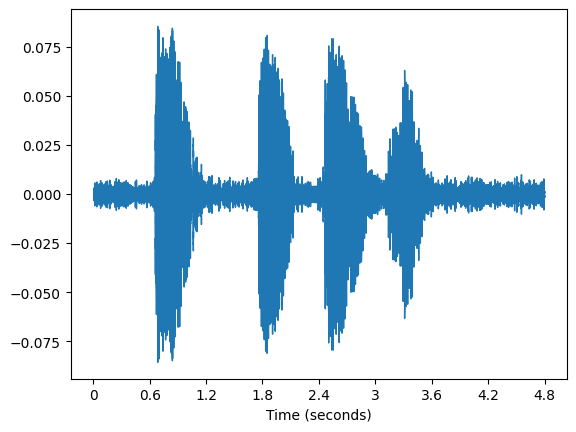

In [2]:
y, sr = librosa.load('/Users/paulchang/Desktop/audio_ml/hello_how_are_u.wav', sr=32000)
librosa.display.waveshow(y, max_points=11025, x_axis='s')
print("The sampled audio is returned as a numpy array (TS) and has ", y.shape, " number of samples")
print("The 10 randomly picked consequitive samples of the audio are: " , y[3000:3010])

Sampling rate tells us how many samples the audio will be broken down into per second. We can extract features from the time domain signal, or convert it into the frequency domain signal.

In [3]:
# Hear the audio
Audio('/Users/paulchang/Desktop/audio_ml/hello_how_are_u.wav')

The Spectrum is the set of frequencies that make up a specific signal. The lowest frequency in a signal called the fundamental frequency. Frequencies that are whole number multiples of the fundamental frequency are known as harmonics. The spectrum of a signal (especially of a non-periodic) changes with time. Therefore, the common approach is to find the spectrum for small fixed section of a signal at a time. This is repeated until we have traversed all of sampled signal. The spectrum for all of the individual sections of a signal are stacked together and that gives us the spectrogram. 

Another key thing is that spectrum is found by taking the Fourier Transform of the signal in a time domain. The approach that is normally taken in to divide the sampled signal into equal parts and take the Fourier Transform of each part individually. This is also called STFT because we are taking Fourier Transform for a small segment of a signal (short term). Therefore, when we want to take the STFT of a signal, we need to specify how many samples we should consider at a time.

Spectrogram is represented as a matrix.

In [4]:
# Size of the Fast Fourier Transform (FFT), which will also be used as the window length
n_fft=2048

# Step or stride between windows. If the step is smaller than the window lenght, the windows will overlap
hop_length=512

# Specify the window type for FFT/STFT
window_type = 'hann'

# Calculate the spectrogram as the square of the complex magnitude of the STFT
spectrogram_librosa = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type)) ** 2

print("The shape of spectrogram_librosa is: ", spectrogram_librosa.shape)
print("The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])")
print("The frame size that we have specficied is the number of samples to consider for the STFT. In our case, it is equal to the n_fft",n_fft, " samples")
print("The number of frames depends on the total lenght of the sampled signal, the number of samples in each frame and the hop lenghth.")

The shape of spectrogram_librosa is:  (1025, 207)
The size of the spectrogram is ([(frame_size/2) + 1 x number of frames])
The frame size that we have specficied is the number of samples to consider for the STFT. In our case, it is equal to the n_fft 2048  samples
The number of frames depends on the total lenght of the sampled signal, the number of samples in each frame and the hop lenghth.


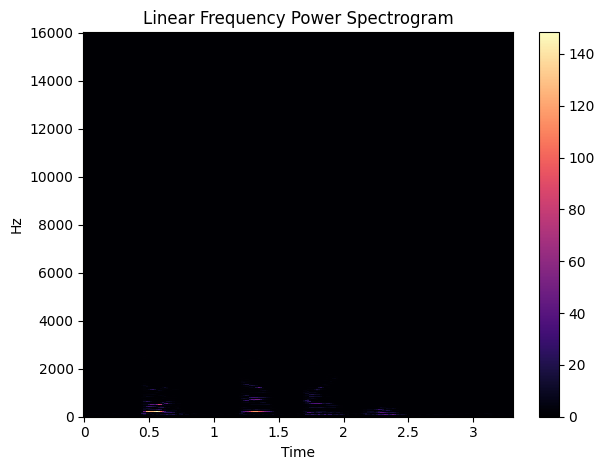

In [5]:
librosa.display.specshow(spectrogram_librosa, sr=sr, x_axis='time', y_axis='linear', hop_length=hop_length)
plt.title('Linear Frequency Power Spectrogram')
plt.colorbar()
plt.tight_layout()
plt.show()

The change of scale is done so that we can actually get a spectrogram from which we can visually infer some meaningful information. The spectrogram above is hard to read as our hearing range is limited to a small set of frequencies and amplitudes.

Humans perceive amplitude of a sound as its loudness. We hear loudness logarithmically rather than linearly. This is accounted for with a Decibel scale. 0 dB is silence. 10 dB is 10 times louder than 0 dB. 20 dB is 100 times louder, 30 dB is 1000 times louder, and so on...

meaning we can easily tell the differences between lower frequencies (such as between 100 Hz and 200 Hz) but we can hardly tell the differences between higher frequencies (such as 10000 Hz and 100100 Hz). In both cases, the difference in frequency is 100 Hz but to a human ear, 200 Hz appears farther apart than 100 Hz. However, looking at it differently, in the 100 Hz - 200 Hz pair, the second frequency is double the first frequency, whereas in the 10000 Hz - 100100 Hz pair, the second frequency is only 1% more than the first one. Therefore, we can say that we hear them on a logarithmic scale rather than a linear scale. This gave rise to a Mel scale.

It is important for us to use a logarithmic scale via the Mel Scale (for frequency) and the Decibel scale (for amplitude) when dealing with Frequencies and Amplitudes for an audio input.

The mel scale is a non-linear transformation of frequency scale based on the perception of pitches. The mel scale is calculated so that two pairs of frequencies separated by a delta in the mel scale are perceived by humans as being equidistant.

In ML applications involving speech and audio, we typically want to represent the power spectrogram in the mel scale domain. We do that by applying a bank of overlapping triangular filters (called Mel filter bank) that compute the energy of the spectrum in each band.

The shape of the Mel spectrogram is [number of mel bands x (frame_size / 2)] + 1, where frame_size is the number of FFR components (n_fft)

The shape of mel spectrogram is:  (64, 207)


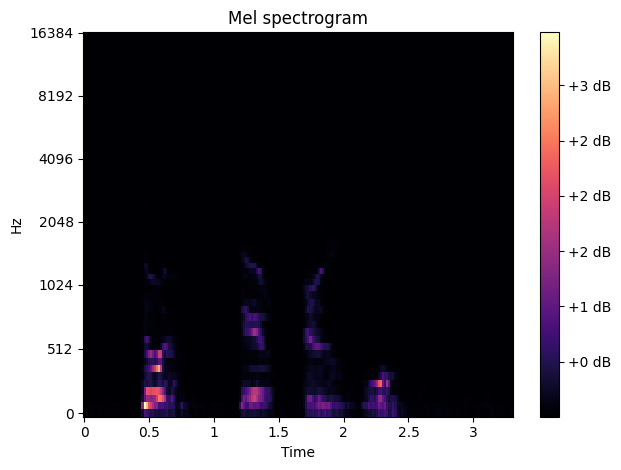

In [7]:
mel_bins = 64
fmin = 0
fmax = sr // 2
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, win_length=n_fft, window=window_type, n_mels=mel_bins, fmin=fmin, fmax=fmax)
print("The shape of mel spectrogram is: ", mel_spectrogram.shape)

librosa.display.specshow(mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

The shape of Log Mel spectrogram is  (64, 207)


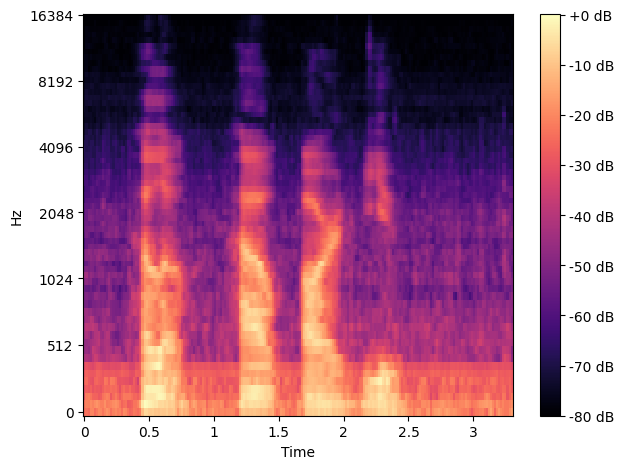

In [8]:
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
print("The shape of Log Mel spectrogram is ", mel_spectrogram_db.shape)
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [9]:
# Parameters for windowing
window_size = int(0.025 * sr)  # 25 ms
stride = int(0.010 * sr)       # 10 ms

# Calculate the number of segments
num_segments = (len(y) - window_size) // stride + 1

# Initialize an array to hold the segments
segments = np.empty((num_segments, window_size))

# Extract the segments
for i in range(num_segments):
    start = i * stride
    end = start + window_size
    segments[i] = y[start:end]

# Energy thresholding to detect speech
energy = np.sum(segments**2, axis=1)  # Compute energy of each segment
energy_threshold = np.max(energy) * 0.1  # Set a threshold for speech detection (10% of max energy)

# Detect phoneme segments
phoneme_indices = np.where(energy > energy_threshold)[0]

# Combine consecutive indices into intervals
intervals = []
start_idx = phoneme_indices[0]
for i in range(1, len(phoneme_indices)):
    if phoneme_indices[i] != phoneme_indices[i - 1] + 1:
        intervals.append((start_idx, phoneme_indices[i - 1]))
        start_idx = phoneme_indices[i]
intervals.append((start_idx, phoneme_indices[-1]))

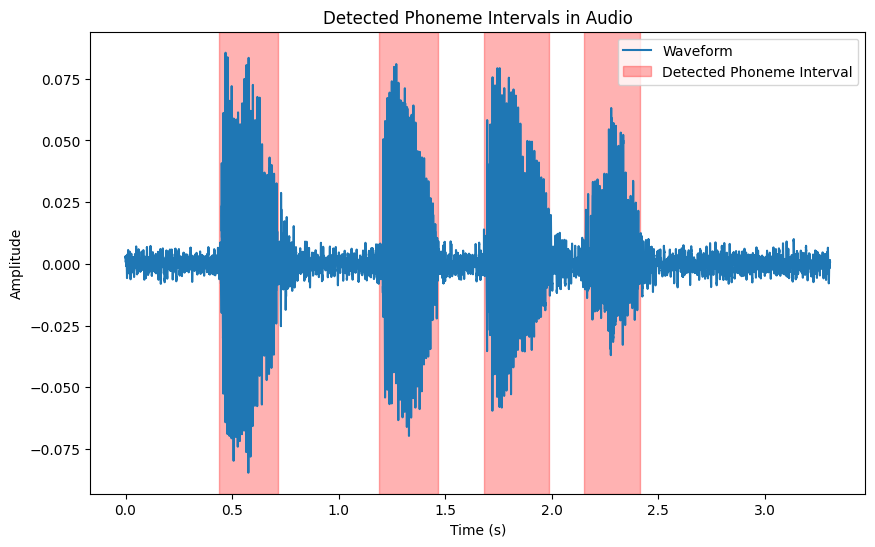

Detected phoneme intervals: [(44, 69), (119, 144), (168, 196), (215, 239)]


In [10]:
# Visualize detected phoneme intervals with time on x-axis
t = np.linspace(0, len(y) / sr, len(y))
plt.figure(figsize=(10, 6))
plt.plot(t, y, label='Waveform')
for start, end in intervals:
    plt.axvspan(start * stride / sr, (end * stride + window_size) / sr, color='r', alpha=0.3, label='Detected Phoneme Interval' if start == intervals[0][0] else "")
plt.title('Detected Phoneme Intervals in Audio')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Print detected phoneme intervals
print("Detected phoneme intervals:", intervals)

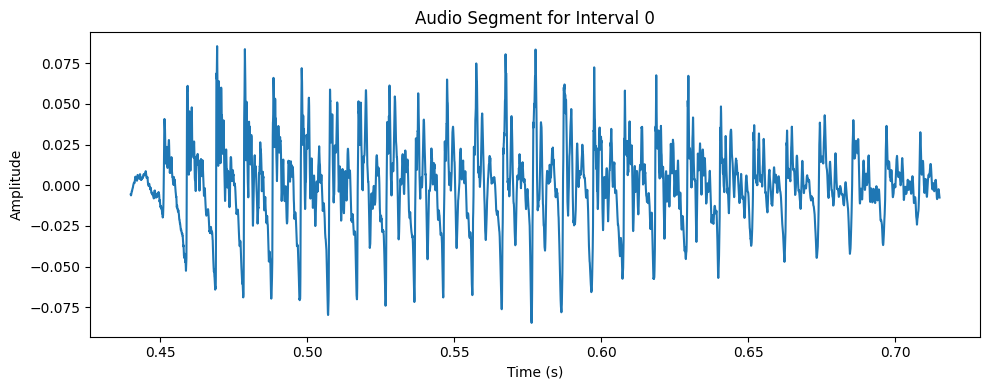

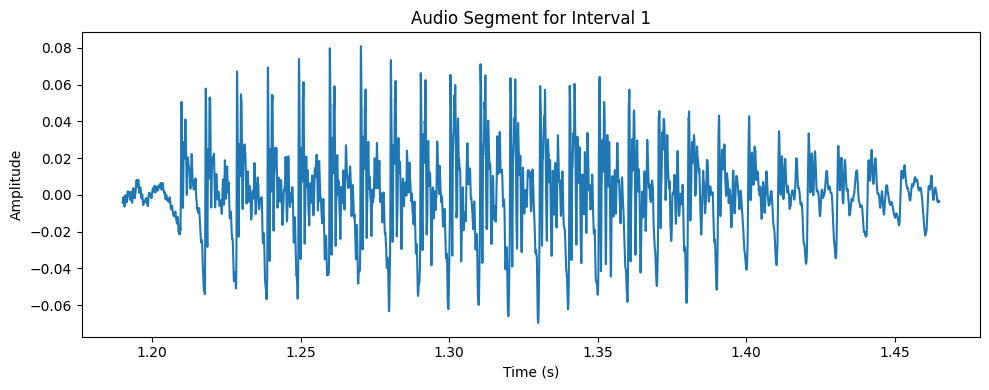

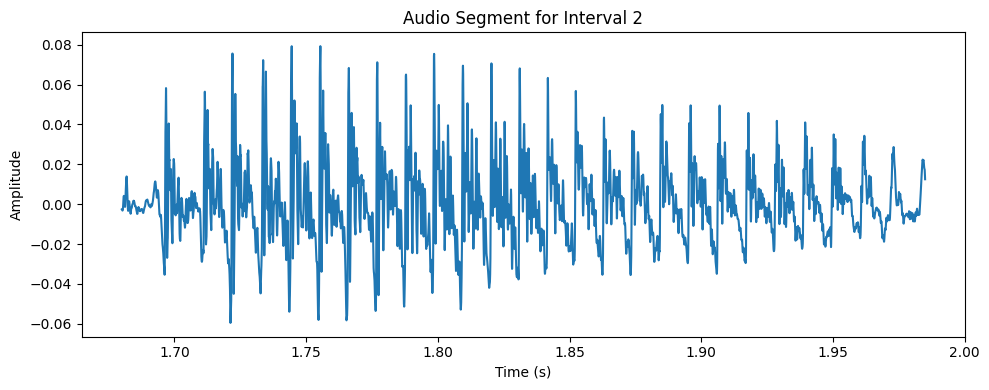

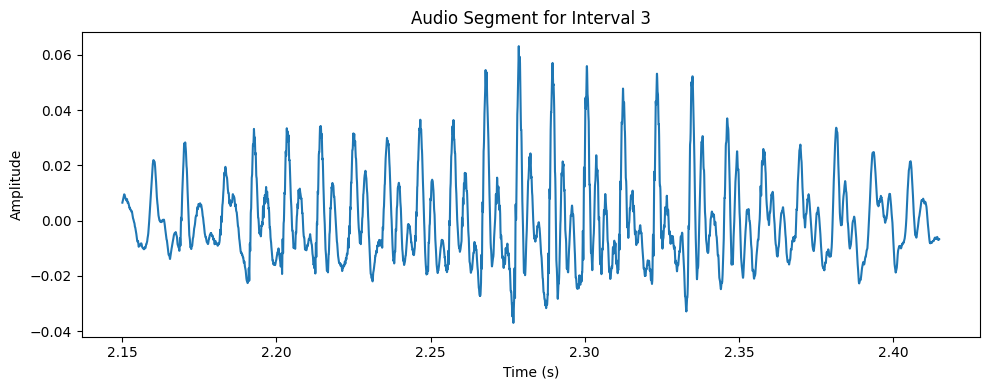

In [11]:
# Function to extract and plot audio segments with correct time intervals
def extract_and_plot_segment(y, sr, start, end, interval_idx):
    # Extract segment
    segment = y[start:end]

    # Create time axis for the segment
    t = np.linspace(start / sr, end / sr, len(segment))
    
    # Visualize the segment
    plt.figure(figsize=(10, 4))
    plt.plot(t, segment)
    plt.title(f'Audio Segment for Interval {interval_idx}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()

# Extract and plot audio segments for each detected interval
for idx, (start, end) in enumerate(intervals):
    #update count for each word 
    extract_and_plot_segment(y, sr, start * stride, end * stride + window_size, idx)

In [12]:
# Function to extract, normalize MFCCs and convert to tensor
def extract_normalize_and_convert_to_tensor(y, sr, start, end):
    # Extract segment
    segment = y[start:end]
    
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=13)
    
    # Normalize the MFCC features
    mfcc_normalized = (mfccs - np.mean(mfccs)) / np.std(mfccs)
    
    # Convert to tensor
    mfcc_tensor = tf.convert_to_tensor(mfcc_normalized, dtype=tf.float32)
    
    return mfcc_tensor

# Extract, normalize MFCCs and convert to tensor for each detected interval
mfcc_tensors = []
for idx, (start, end) in enumerate(intervals):
    mfcc_tensor = extract_normalize_and_convert_to_tensor(y, sr, start * stride, end * stride + window_size)
    mfcc_tensors.append(mfcc_tensor)
    print(f"MFCC Tensor for Interval {idx}: {mfcc_tensor}")

MFCC Tensor for Interval 0: [[-3.32029176e+00 -2.75341511e+00 -2.55662465e+00 -2.60458398e+00
  -2.74960923e+00 -2.85884428e+00 -2.95296907e+00 -3.02058029e+00
  -3.01620173e+00 -2.96625495e+00 -2.81790853e+00 -2.80412912e+00
  -2.92128921e+00 -3.11818886e+00 -3.34032059e+00 -3.45453596e+00
  -3.45477033e+00 -3.41441941e+00]
 [ 1.66385508e+00  1.97390544e+00  1.98881495e+00  1.85842788e+00
   1.81758904e+00  1.79918277e+00  1.78283072e+00  1.78959739e+00
   1.81821144e+00  1.81040239e+00  1.84952068e+00  1.87526977e+00
   1.92641652e+00  1.96513140e+00  2.00076056e+00  2.05419707e+00
   1.93975246e+00  1.61807346e+00]
 [ 4.67168316e-02 -1.98280573e-01 -2.64753848e-01 -1.97564766e-01
  -1.03836559e-01 -4.74048294e-02 -2.55841855e-02 -6.41856389e-03
   1.78935081e-02  1.95324495e-02 -6.52785599e-02 -1.34549916e-01
  -1.37242705e-01 -1.41335875e-01 -8.88286605e-02 -7.07343454e-04
   1.14019975e-01  2.55291581e-01]
 [ 1.77524030e-01  2.71069378e-01  3.49706262e-01  3.84336203e-01
   4.3316

MFCC Tensor for Interval 0: (13, 18)


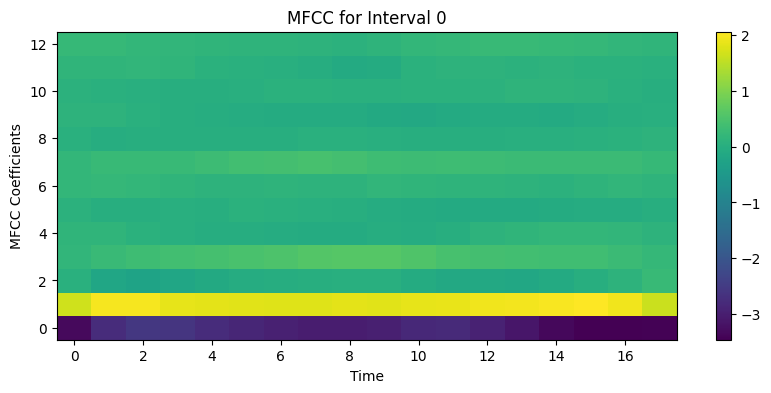

MFCC Tensor for Interval 1: (13, 18)


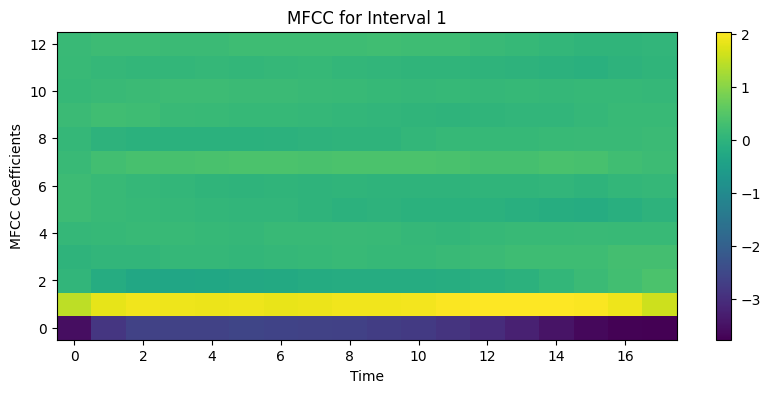

MFCC Tensor for Interval 2: (13, 20)


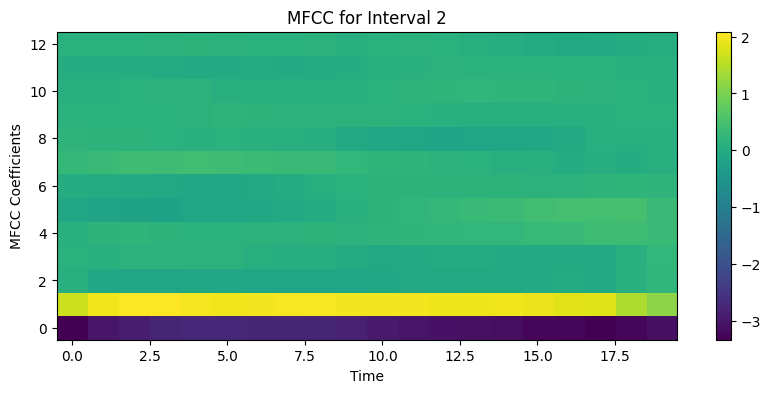

MFCC Tensor for Interval 3: (13, 17)


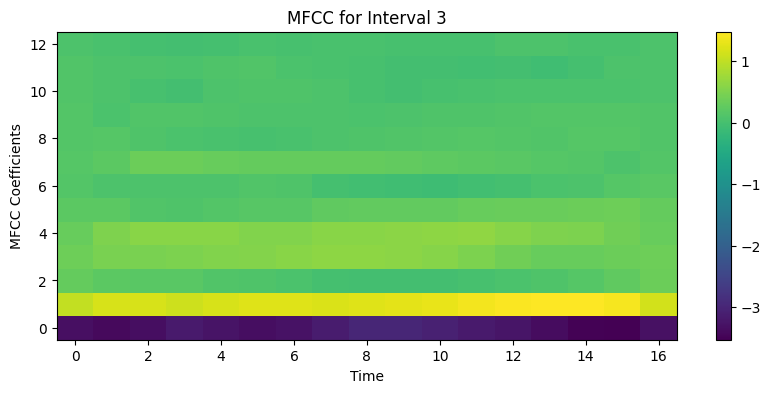

In [13]:
# Display MFCC tensors for each interval
for idx, mfcc_tensor in enumerate(mfcc_tensors):
    print(f"MFCC Tensor for Interval {idx}: {mfcc_tensor.shape}")
    plt.figure(figsize=(10, 4))
    plt.imshow(mfcc_tensor.numpy(), aspect='auto', origin='lower')
    plt.title(f'MFCC for Interval {idx}')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.colorbar()
    plt.show()

In [14]:
def calculate_energy(signal):
    return np.sum(signal ** 2) / len(signal)

def calculate_zero_crossings(signal):
    return librosa.zero_crossings(signal, pad=False).sum()

def extract_phoneme_boundaries(segment, sr):
    frame_length = int(0.010 * sr)  # 10 ms frames
    hop_length = int(0.005 * sr)    # 5 ms hop
    energies = []
    zcrs = []

    # Analyze frames within the segment
    for i in range(0, len(segment) - frame_length, hop_length):
        frame = segment[i:i + frame_length]
        energies.append(calculate_energy(frame))
        zcrs.append(calculate_zero_crossings(frame))

    # Normalize energy and zcr for thresholding
    norm_energies = (energies - np.mean(energies)) / np.std(energies)
    norm_zcrs = (zcrs - np.mean(zcrs)) / np.std(zcrs)

    # Detect boundaries where energy or zcr exceeds their respective thresholds
    energy_threshold = 1.0  # threshold for normalized energy
    zcr_threshold = 1.0     # threshold for normalized zcr
    boundaries = [0]  # start with the beginning of the segment

    for i in range(1, len(norm_energies)):
        if norm_energies[i] > energy_threshold or norm_zcrs[i] > zcr_threshold:
            time_index = i * hop_length + frame_length // 2
            boundaries.append(time_index)

    # Ensure the last boundary is the end of the segment
    if boundaries[-1] != len(segment):
        boundaries.append(len(segment))

    return boundaries

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encount

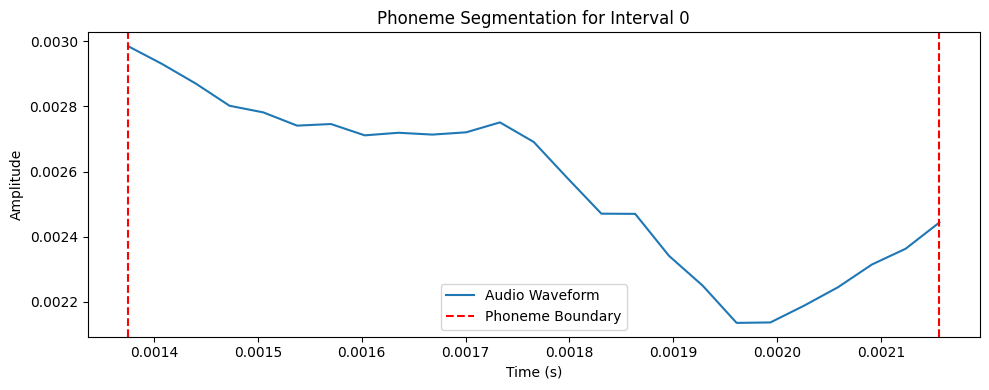

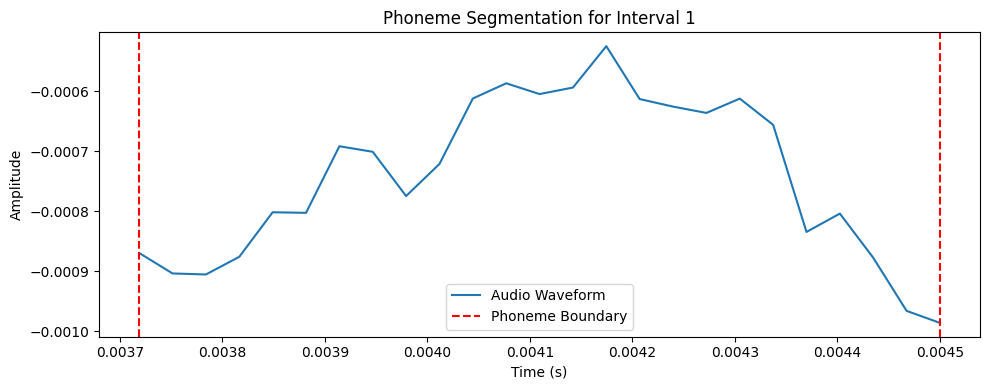

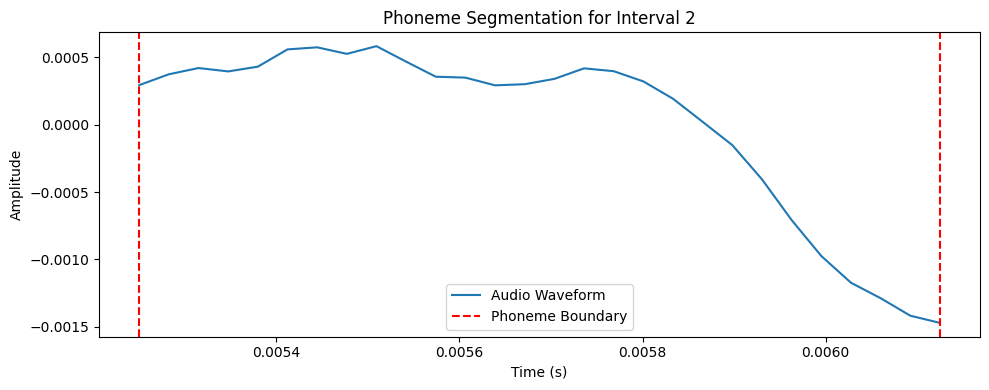

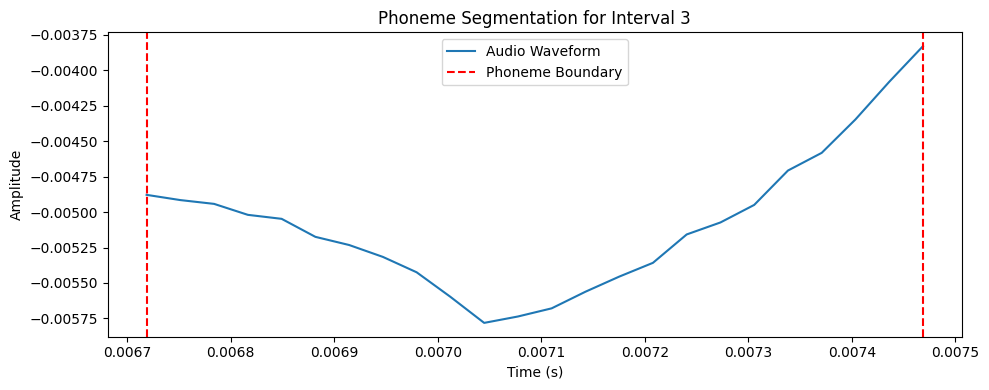

In [15]:
def extract_and_plot_segment(y, sr, start, end, interval_idx):
    # Extract segment
    segment = y[start:end]

    # Detect phoneme boundaries within the segment
    phoneme_boundaries = extract_phoneme_boundaries(segment, sr)

    # Create time axis for the segment
    t = np.linspace(start / sr, end / sr, len(segment))
    
    # Visualize the segment
    plt.figure(figsize=(10, 4))
    plt.plot(t, segment, label='Audio Waveform')
    # Convert boundary indices to time
    boundary_times = [(start + b) / sr for b in phoneme_boundaries]
    for bt in boundary_times:
        plt.axvline(x=bt, color='red', linestyle='--', label='Phoneme Boundary' if bt == boundary_times[0] else "")
    plt.title(f'Phoneme Segmentation for Interval {interval_idx}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
for idx, (start, end) in enumerate(intervals):
    extract_and_plot_segment(y, sr, start, end, idx)